In [1]:
import torch 
from torch import nn 
from einops import rearrange

class JigsawAugmentation(nn.Module): 
    # x tiles and y tiles must perfectly divide the image dimension
    def __init__(self, x_tiles: int, y_tiles: int):
        super().__init__()
        self.x_tiles = x_tiles 
        self.y_tiles = y_tiles

    def forward(self, image): 
        B, _, H, W = image.shape
        assert H % self.x_tiles == 0 
        assert H % self.y_tiles == 0 

        # each image is split into subgrids
        grids = rearrange(image, 'b c (hs h) (ws w) -> b (hs ws) c h w', hs=self.y_tiles, ws=self.x_tiles)

        # generate shuffle indices 
        indices = torch.argsort(torch.rand((B, self.x_tiles * self.y_tiles)), dim=-1)
        # shuffle the jigsaw 
        grids = grids[torch.arange(B).unsqueeze(-1),indices, :, :, :]
        grids = rearrange(grids, 'b (hs ws) c h w -> b c (hs h) (ws w)', hs=self.y_tiles, ws=self.x_tiles)
        return grids 


In [2]:
import matplotlib.pyplot as plt
def show_image(image): 
    plt.figure()
    return plt.imshow(image.permute(1, 2, 0))

In [3]:
## load image dataset 
from hydra.utils import instantiate 
from hydra import initialize, compose

with initialize("../configs"): 
    dataset = instantiate(compose("val_dataset/imagenette_val.yaml")).val_dataset


In [4]:
from torch.utils.data import DataLoader

dataloader = DataLoader(dataset, batch_size=5)

# grab 1 batch 
for b in dataloader: 
    image, y = b
    break


In [6]:
aug = JigsawAugmentation(8, 8)
augmented = aug(image)

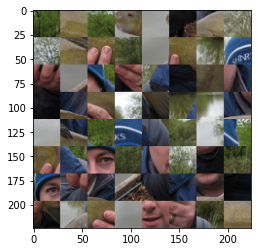

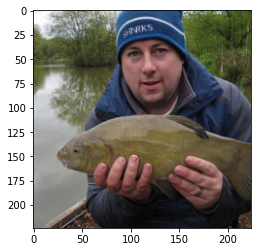

In [10]:
show_image(augmented[3])
show_image(image[3])

torch.Size([5, 3, 224, 224])


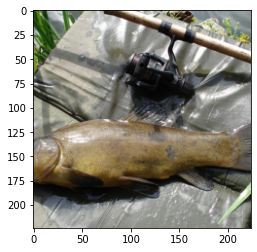

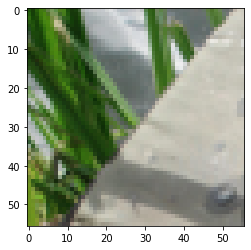

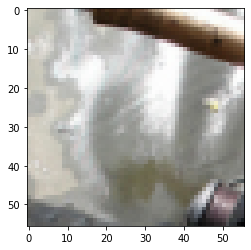

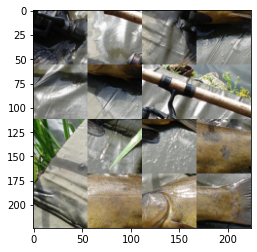

In [79]:
print(image.shape)
B, _, H, W = image.shape
show_image(image[0])
grids = rearrange(image, 'b c (hs h) (ws w) -> b (hs ws) c h w', hs=4, ws=4)
show_image(grids[0][0])
show_image(grids[0][1])
# # generate shuffle indices 
indices = torch.argsort(torch.rand((B, 16)), dim=-1)
# # shuffle the jigsaw 
grids = grids[torch.arange(B).unsqueeze(-1),indices, :, :, :]
grids = rearrange(grids, 'b (hs ws) c h w -> b c (hs h) (ws w)', hs=4, ws=4)
show_image(grids[0])

In [64]:
from torchvision.transforms import RandomCrop
from torchvision.transforms.functional import pad
import torch

class CropAndShift(torch.nn.Module): 
    def __init__(self, crop_size: int, shift: bool): 
        super().__init__()
        self.crop = RandomCrop(crop_size)
        self.crop_size = crop_size
        self.shift = shift
        
    def forward(self, image): 
        _, _, H, W = image.shape
        assert H > self.crop_size 
        assert W > self.crop_size
        
        image = self.crop(image)
        x_remain = W - self.crop_size
        y_remain = H - self.crop_size
        if self.shift: 
            left_pad = torch.randint(x_remain, (1, 1)).item()
            top_pad = torch.randint(y_remain, (1, 1)).item()
        else: 
            left_pad = (x_remain) // 2 
            top_pad = (y_remain) // 2 
            
        return pad(image, padding=[left_pad, top_pad, x_remain - left_pad, y_remain-top_pad])
        
        
        
        
        

In [69]:
aug = CropAndShift(150, shift=True)
output = aug(image)
print(output.shape)

torch.Size([5, 3, 224, 224])


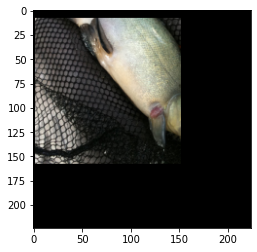

In [74]:
show_image(output[4])